<a href="https://colab.research.google.com/github/mohsenh17/jaxLearning/blob/main/flax/parallelMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install --upgrade flax orbax jax treescope

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 7.1 MB/s eta 0:00:00
  Created wheel for orbax: filename=orbax-0.1.9-py3-none-any.whl size=1493 sha256=1650aefed1b55d3d18c5cc6ac23006d9bea9bc276602362dabf1bb01caf424a1
  Stored in directory: /root/.cache/pip/wheels/14/7a/98/b955a4db98b54317c311ee32367994ca530721c62a87ec56a7
Successfully built orbax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
  Attempting uninstall: flax
    Found existing installation: flax 

In [2]:
import os
import jax
import jax.numpy as jnp
from jax.sharding import PartitionSpec as P, Mesh
from jax.experimental.shard_map import shard_map
from jax.experimental import mesh_utils

import optax
from flax import nnx
import matplotlib.pyplot as plt

from functools import partial
import numpy as np

In [3]:
USE_CPU_ONLY = True

flags = os.environ.get("XLA_FLAGS", "")
if USE_CPU_ONLY:
    flags += " --xla_force_host_platform_device_count=8"  # Simulate 8 devices
    # Enforce CPU-only execution
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
else:
    # GPU flags
    flags += (
        "--xla_gpu_enable_triton_softmax_fusion=true "
        "--xla_gpu_triton_gemm_any=false "
        "--xla_gpu_enable_async_collectives=true "
        "--xla_gpu_enable_latency_hiding_scheduler=true "
        "--xla_gpu_enable_highest_priority_async_stream=true "
    )
os.environ["XLA_FLAGS"] = flags

print(f'You have 8 “fake” JAX devices now: {jax.devices()}')

You have 8 “fake” JAX devices now: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [53]:
from flax.nnx.nn import dtypes, initializers
class MLP(nnx.Module):
  def __init__(self, din, dmid, dout, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid,
                              kernel_init=nnx.with_partitioning(initializers.lecun_normal(),(None, 'model')),
                              bias_init=nnx.with_partitioning(initializers.zeros_init(),('model',)),
                              #use_bias=False,
                              rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout,
                              kernel_init=nnx.with_partitioning(initializers.lecun_normal(),(None, 'model')),
                              bias_init=nnx.with_partitioning(initializers.zeros_init(),('model',)),
                              #use_bias=False,
                              rngs=rngs)
  def __call__(self, x):
    return self.linear2(nnx.relu(self.linear1(x)))
# Instantiate the MLP model
model = MLP(1, 64, 1, rngs=nnx.Rngs(0))


In [51]:
mesh = Mesh(devices=np.array(jax.devices()).reshape(2, 4),
            axis_names=('data', 'model'))
print(mesh)

Mesh('data': 2, 'model': 4)


In [54]:
@nnx.jit
def create_sharded_model(model):
  state = nnx.state(model)                   # The model's state, a pure pytree.
  pspecs = nnx.get_partition_spec(state)     # Strip out the annotations from state.
  #print(state)
  sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
  nnx.update(model, sharded_state)           # The model is sharded now!
  return model
with mesh:
  sharded_model = create_sharded_model(model)

In [55]:
# Learning rate and momentum for the optimizer
learning_rate = 0.005
momentum = 0.9


# Set up the optimizer using Adam with the specified learning rate
optimizer = nnx.Optimizer(sharded_model, optax.adam(learning_rate))

# Initialize metrics for tracking training performance
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),  # Tracks the average loss
)

In [56]:
print("sharded_model.linear1.kernel (None, 'model') :")
jax.debug.visualize_array_sharding(sharded_model.linear1.kernel.value)

sharded_model.linear1.kernel (None, 'model') :


data sharding


           
           
CPU 0,1,2,3
           
           
           
           
           
CPU 4,5,6,7
           
           
           

step=0, loss=4.9042510986328125
step=100, loss=0.06768321245908737
step=200, loss=0.04404439404606819
step=300, loss=0.027956079691648483
step=400, loss=0.025344233959913254
step=500, loss=0.011276581324636936
step=600, loss=0.0075743477791547775
step=700, loss=0.010263665579259396
step=800, loss=0.00773665402084589
step=900, loss=0.007701881695538759


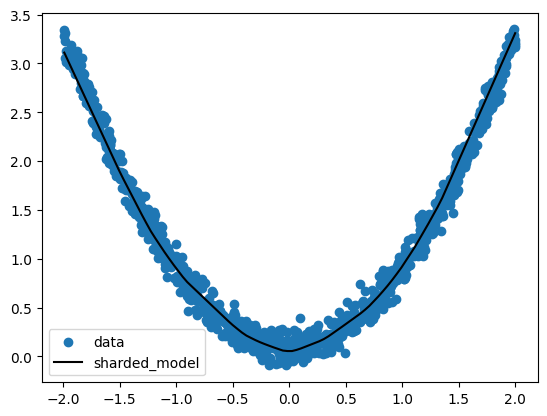

In [57]:
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, x, y):
  def loss_fn(model: MLP):
    y_pred = model(x)
    return jnp.mean((y - y_pred) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)
  return loss


def dataset(steps, batch_size):
  for _ in range(steps):
    x = np.random.uniform(-2, 2, size=(batch_size, 1))
    y = 0.8 * x**2 + 0.1 + np.random.normal(0, 0.1, size=x.shape)
    yield x, y


for step, (x, y) in enumerate(dataset(1000, 16)):
  # shard data
  x, y = jax.device_put((x, y), jax.NamedSharding(mesh, jax.sharding.PartitionSpec('data')))
  # train
  loss = train_step(sharded_model, optimizer, x, y)

  if step == 0:
    print('data sharding')
    jax.debug.visualize_array_sharding(jnp.array(x))

  if step % 100 == 0:
    print(f'step={step}, loss={loss}')

# dereplicate state
state = nnx.state((sharded_model, optimizer))
state = jax.device_get(state)
nnx.update((sharded_model, optimizer), state)

X, Y = next(dataset(1, 1000))
x_range = np.linspace(X.min(), X.max(), 100)[:, None]
y_pred = sharded_model(x_range)

# plot
plt.scatter(X, Y, label='data')
plt.plot(x_range, y_pred, color='black', label='sharded_model')
plt.legend()
plt.show()